In [1]:
# Preliminary data notebook for
# NIH: Imaging Guided Intervention Surgery Study Section

# Exploratory aim: evaluate presurgical scans between STN and GPi targets
#   Given retrospective GPi acquisitions?
#   Search for radiomic differentiators for STN versus GPi selection in presurgical scans

In [2]:
# Import libraries
from datetime import date, datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import scipy.stats as stats
import os
import pickle

%matplotlib widget

In [3]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2

load_data = 0
rextract = 0
retrain = 1
# Load data
# fig,ax = plt.subplots(2,5)
segs = []
qsms = []
voxel_sizes = []
trackers = []
directory = 'F:\dbs\stn-dbs\Cornell_anonymized'
case_list = []
if load_data == 1:
    for filename in os.listdir(directory):
        f = os.path.join(directory,filename)
        print(f)
    
        seg = nib.load(f+'/Rh Mri Brain With Without Contrast/seg.nii.gz')
                    
        voxel_size = seg.header['pixdim'][0:3]
        voxel_sizes.append(voxel_size)
        segs.append(seg.get_fdata())

        qsm = nib.load(f+'/Rh Mri Brain With Without Contrast/qsm.nii.gz')
        qsms.append(qsm.get_fdata())
            
        case_list.append(filename)
        n_cases = len(segs)

        label_min = np.partition(np.unique(seg.get_fdata().ravel()),1)[1]
        label_max = np.amax(seg.get_fdata())

In [4]:
# Define feature extraction
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.enableAllFeatures()
extractor.enableAllImageTypes()

# Generate feature structure Phi from all ROIs and all cases
if rextract == 1:
    Phi = []

    # Training cases
    for i in range(n_cases):
        seg_sitk = sitk.GetImageFromArray(segs[i])
        seg_sitk.SetSpacing(voxel_sizes[i].tolist())
        qsm_sitk = sitk.GetImageFromArray(qsms[i])
        qsm_sitk.SetSpacing(voxel_sizes[i].tolist())
        for j in range(int(label_min),int(label_max+1)):
            featureVector = extractor.execute(qsm_sitk,seg_sitk,label=j)
            Phi.append(featureVector)
    # Save feature vector
    with open('../features/Phi_57','wb') as fp:  
        pickle.dump(Phi,fp)


In [5]:
with open('../features/Phi_57','rb') as fp:  
    Phi = pickle.load(fp)

In [6]:
%%html
   <style>
   .cell-output-ipywidget-background {
      background-color: transparent !important;
   }
   .jp-OutputArea-output {
      background-color: transparent;
   }  
   </style>
   

In [7]:
 # SAS features 
subject_id = np.linspace(1,27,27)
pre_sas_on = np.array((8,2,12,17,11,22,2,5,13,4,11,7,7,16,9,8,9,13,10,11,6,5,17,12,11,21,9)).T
post_sas_on = np.array((21,3,19,13,13,14,11,12,23,12,4,6,11,28,17,8,21,8,17,11,9,20,17,19,15,19,11)).T
per_change = (pre_sas_on-post_sas_on)/pre_sas_on
pre_sas_off = np.array((13,2,9,20,21,12,3,27,22,29,30,17,13,27,9,8,16,31,10,2,8,5,17,14,8,12,8))
lct_change = (pre_sas_off-pre_sas_on)/pre_sas_off
dbs_change = (post_sas_on-pre_sas_off)/pre_sas_off
ap = np.array(('Y','N','Y','Y','Y','Y','N','Y','Y','Y','Y','Y','N','Y','Y','N','Y','Y','Y','Y','N','N','Y','N','Y','N','N')).T
ap[ap=='Y'] = 1 
ap[ap=='N'] = 0
bi_sas = (np.array(ap)).astype('float')
n_cases = pre_sas_on.__len__()

In [8]:
case_id = np.repeat(subject_id,2)

In [9]:
n_cases = subject_id.__len__()

In [10]:
ut = np.zeros((subject_id.__len__()))
for j in np.arange(1,np.max(subject_id)+1):
    if j in subject_id:
        # Extract numeric feature values
        n_ROIs = 2
        x_row = []
        x_row_t = []
        keys = []
        per_change_train = []
        for i in range(Phi.__len__()//2+1):
            if i in subject_id:
                for ii in range(0,n_ROIs-1):
                    featureVector = Phi[i+ii]
                    for key,value in six.iteritems(featureVector):
                        if 'diagnostic' in key:
                            next
                        else:
                            try:
                                x_row.append(value.ravel())
                            except:
                                x_row.append(value)
                            keys.append(key)
                    if ii == 0 and pre_sas_off[subject_id == i].__len__()>0:
                        x_row.append(pre_sas_off[subject_id == i])
                        x_row.append(pre_sas_on[subject_id == i])
                        x_row.append(bi_sas[subject_id == i])
                        keys.append('pre_sas_off')
                        keys.append('pre_sas_on')
                        keys.append('bi_sas')
                        per_change_train.append(per_change[subject_id == i])
                        
        jj = int(np.where(subject_id==j)[0])
        X0 = np.array(x_row)
        X = X0.reshape((n_cases,int(len(X0)/(n_cases))))
        X0_t = X[jj,:]
       
        # Normalize testing and training cases together
        #   Set with_mean=False to preserve data sparsity
        #   And with_std=False 
        #   However,need a significant number of samples to do this
        scaler = StandardScaler()
        X_all = np.vstack((X,X0_t))
        X_all_t = scaler.fit_transform(X_all)
        X_t = X_all_t[X.shape[0]:,:]
        Xin = X_all_t[:X.shape[0]]



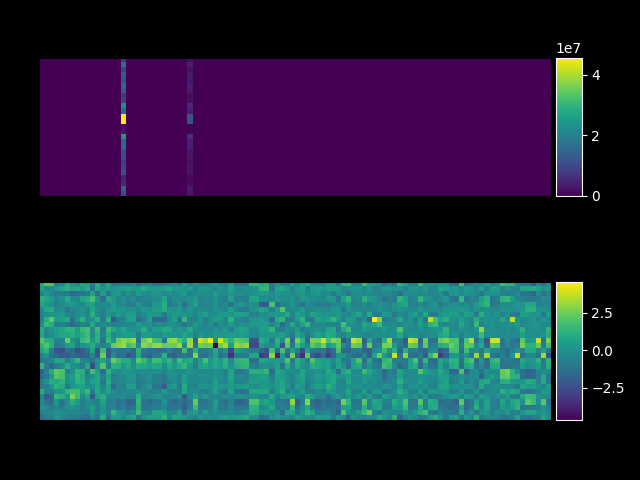

In [11]:
fig,ax = plt.subplots(2,1)
plt.style.use('dark_background')
im0 = ax[0].imshow(X[:,0:100])
im1 = ax[1].imshow(Xin[:,0:100])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xlabel('Feature index')
ax[0].set_ylabel('Case')
ax[1].set_ylabel('Case')
divider0 = make_axes_locatable(ax[0])
divider1 = make_axes_locatable(ax[1])
cax0 = divider0.append_axes('right',size='5%',pad=0.05)
fig.colorbar(im0,cax=cax0,orientation='vertical')
cax1 = divider1.append_axes('right',size='5%',pad=0.05)
fig.colorbar(im1,cax=cax1,orientation='vertical')
ax[1].set_title('Standardized feature matrix')
ax[0].set_title('Feature matrix $X$');
plt.tight_layout()



In [13]:
if retrain == 1:
    for j in np.arange(1,np.max(subject_id)+1):
        if j in subject_id:
            # Remove the test case
            jj = int(np.where(subject_id==j)[0])
            X_j = np.delete(Xin,jj,0)
            per_change_train_j = np.delete(per_change_train,jj,0)
            # Debug
            # print('Excluding subject',str(subject_id[jj]),'from training feature vector of shape',str(Xin.shape),'to create new training feature vector of shape',str(X_j.shape))
            if (sum(sum(np.isnan(X))))>0:
                print('NaN detected in feature vector')

            # Cross-validation for model selection
            cv = KFold(X_j.shape[0]-2)
            # Identify most important features
            # Do not assume data is centered,fit_intercept=True
            # Does LassoCV automatically do LOOCV?
            clf_in = LassoCV(fit_intercept=True,max_iter=10000,alphas=(1e-3,1e-2),verbose=1,n_jobs=-1).fit(X_j,np.ravel(per_change_train_j))
            sfm = SelectFromModel(clf_in,max_features=100)
            # Initialize pipeline
            clf = Pipeline([('Lasso',sfm),('SVR',SVR(C=0,epsilon=0,kernel='rbf'))],verbose=1)
            # Select the optimal SVR parameters with grid search
            Cs = ((1e-1,1,10))
            epsilons = ((0.01,0.05,0.1,0.2))
            
            clf_nsvr = GridSearchCV(clf,{'SVR__C':Cs,'SVR__epsilon':epsilons},n_jobs=-1,cv=cv,scoring='neg_mean_squared_error',error_score='raise',verbose=1)
            clf_nsvr.fit(X_j,np.ravel(per_change_train_j))
            ut[jj] = clf_nsvr.best_estimator_.predict(Xin[jj,:].reshape(1,-1))
            print('Predicted percentage change of',ut[jj],'for case',subject_id[jj])
            print('True percentage change',per_change_train[jj])
            print(clf_in.alpha_)
            print(clf_nsvr.best_estimator_.get_params('SVR__epsilon'))
            print(clf_nsvr.best_estimator_.get_params('SVR__C'))



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
..........[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.5s finished


Fitting 24 folds for each of 12 candidates, totalling 288 fits


In [ ]:
if retrain == 1:
    with open('lasso_pred.npy','wb') as f:
        np.save(f,ut)
else:
    with open('lasso_pred.npy','rb') as f:
        ut = np.load(f)

In [ ]:
[fig,ax] = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].hist([lct_change],bins=np.linspace(0,1,100))
ax[0].set_title('Medication response')
ax[0].set_xlabel('Improvement')
ax[0].set_ylabel('Frequency')
ax[1].hist([ut],bins=np.linspace(0,1,100))
ax[1].set_title('Lasso prediction')
ax[1].set_xlabel('Improvement')
ax[1].set_ylabel('Frequency')
fig.set_size_inches(12,6)

In [ ]:
#plt.style.use('dark_background')
[fig,ax] = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].scatter(per_change,lct_change)
z = np.polyfit(per_change,lct_change,1)
p = np.poly1d(z)
r2_score(per_change,p(per_change_train))
ax[0].plot(per_change,p(per_change),'r--')
ax[0].set_title('Medication response')
ax[0].set_xlabel('UPDRS-III pre/post DBS percent improvement')
ax[0].set_ylabel('UPDRS-III percent improvement')
ax[1].text(-0.8,0.05,'y = '+ str(np.round(p[1],2))+'x'+'+' +str(np.round(p[0],3)),color='w')
ax[1].text(-0.8,0.005,'$r^2$ = '+str(np.round(r2_score(per_change,p(per_change)),3)),color='w')
ax[1].scatter(per_change,ut)
z = np.polyfit(per_change,ut,1)
p = np.poly1d(z)
ax[1].plot(per_change,p(per_change),'r--')
ax[1].set_title('Lasso prediction')
ax[1].set_xlabel('UPDRS-III pre/post DBS percent improvement')
ax[1].set_ylabel('Predicted UPDRS-III percent improvement')
ax[1].text(0.2,0.05,'y = '+ str(np.round(p[1],2))+'x'+'+'+str(np.round(p[0],3)),color='w')
ax[1].text(0.2,0.005,'$r^2$ = '+str(np.round(r2_score(per_change,p(per_change)),3)),color='w')
fig.set_size_inches(12,6)
plt.show()

In [ ]:
x = per_change
y = ut

slope,intercept = np.polyfit(x,y,1)  # linear model adjustment
y_model = np.polyval([slope,intercept],x)   # modeling...

x_mean = np.mean(x)
y_mean = np.mean(y)
n = x.size                        # number of samples
m = 2                             # number of parameters
dof = n-m                       # degrees of freedom
t = stats.t.ppf(0.975,dof)       # Students statistic of interval confidence
residual = y-y_model

std_error = (np.sum(residual**2)/dof)**(1/2)   # Standard deviation of the error

# Pearson's correlation coefficient
numerator = np.sum((x-x_mean)*(y-y_mean))
denominator = (np.sum((x-x_mean)**2)*np.sum((y-y_mean)**2))**.5
correlation_coef = numerator/denominator
r = correlation_coef
tr = r*np.sqrt(n-2)/(np.sqrt(1-r**2))
# p-value for 2-sided test
pv = 2*(1-stats.t.cdf(abs(tr), dof))
# # mean squared error
MSE = 1/n*np.sum((y-y_model)**2)

# to plot the adjusted model
x_line = np.linspace(0,np.max(x),100)
y_line = np.polyval([slope,intercept],x_line)

# confidence interval
ci = t*std_error*(1/n+(x_line-x_mean)**2/np.sum((x-x_mean)**2))**.5
# predicting interval
pi = t*std_error*(1+1/n+(x_line-x_mean)**2/np.sum((x-x_mean)**2))**.5  


plt.rcParams.update({'font.size': 14})
[fig,ax] = plt.subplots(1,2,sharex=True,sharey=True)

ax[0].plot(x,y,'o',color = 'white')
ax[0].plot(x_line,y_line,color = 'red')
ax[0].fill_between(x_line,y_line+pi,y_line-pi,color = 'red',label = '95% prediction interval')
ax[0].fill_between(x_line,y_line+ci,y_line-ci,color = 'orange',label = '95% confidence interval')

ax[0].set_xlabel('UPDRS-III pre/post DBS percent improvement')
ax[0].set_ylabel('Percent improvement')
ax[0].set_title('Lasso prediction')

ax[0].text(0.01,0.1,'$y$ = '+ str(np.round(slope,2))+'$x$'+'+'+str(np.round(intercept,3)),color='w')
ax[0].text(0.01,0.005,'$r$ = '+str(np.round(r,2))+', $p$ = '+str(round(pv,3)),color='w')
ax[0].text(0.01,-0.075,'$MSE$ = '+str(np.round(MSE,2)),color='w')
ax[0].margins(x=0)
fig.set_size_inches(20,10)
ax[0].legend(bbox_to_anchor=(1,1),fontsize=12)



## Medication response
x = per_change
y = lct_change

# Fit and evaluate linear model
slope,intercept = np.polyfit(x,y,1)
y_model = np.polyval([slope,intercept],x)   

# Prepare correlation stats
x_mean = np.mean(x)
y_mean = np.mean(y)
# Sample size
n = x.size         
# Parameters assuming a normal distribution              
m = 2
# Degrees of freedom                            
dof = n-m
# Students statistic of interval confidence                      
t = stats.t.ppf(0.975,dof)      
pv = r*np.sqrt(n-2)/(np.sqrt(1-r**2))
# Standard deviation of the error
residual = y-y_model
std_error = (np.sum(residual**2)/dof)**(1/2)   

# Pearson's correlation coefficient
numerator = np.sum((x-x_mean)*(y-y_mean))
denominator = (np.sum((x-x_mean)**2)*np.sum((y-y_mean)**2))**.5
correlation_coef = numerator/denominator
r = correlation_coef
tr = r*np.sqrt(n-2)/(np.sqrt(1-r**2))
# p-value for 2-sided test
pv = 2*(1-stats.t.cdf(abs(tr), dof))

# mean squared error
MSE = 1/n*np.sum((y-y_model)**2)

# to plot the adjusted model
x_line = np.linspace(0,np.max(x),100)
y_line = np.polyval([slope,intercept],x_line)

# confidence interval
ci = t*std_error*(1/n+(x_line-x_mean)**2/np.sum((x-x_mean)**2))**.5
# predicting interval
pi = t*std_error*(1+1/n+(x_line-x_mean)**2/np.sum((x-x_mean)**2))**.5  


ax[1].plot(x,y,'o',color = 'white')
ax[1].plot(x_line,y_line,color = 'red')
ax[1].fill_between(x_line,y_line+pi,y_line-pi,color = 'red',label = '95% prediction interval')
ax[1].fill_between(x_line,y_line+ci,y_line-ci,color = 'orange',label = '95% confidence interval')

ax[1].set_xlabel('UPDRS-III pre/post DBS percent improvement')
ax[1].set_ylabel('Percent improvement')
ax[1].set_title('Medication response')


ax[1].text(0.01,0.1,'$y$ = '+ str(np.round(slope,2))+'$x$'+'+'+str(np.round(intercept,3)),color='w')
ax[1].text(0.01,0.005,'$r$ = '+str(np.round(r,2))+', $p$ = '+str(round(pv,3)),color='w')
ax[1].text(0.01,-0.075,'$MSE$ = '+str(np.round(MSE,2)),color='w')
ax[1].margins(x=0)
fig.set_size_inches(20,10)
ax[1].legend(bbox_to_anchor=(1,1),fontsize=12)
fig.suptitle('UPDRS-III Improvement')

In [ ]:
if retrain == 1:
    feats = clf_nsvr.best_estimator_.steps[0][1].get_support()
    with open('lasso_feats.txt','w') as f:
        f.write('Lasso selected features from model trained on '+str(datetime.now())+'\n')
    for k in range(feats.__len__()-1):
        if feats[k] == True:
            with open('lasso_feats.txt','a') as f:
                f.write(keys[k]+'\n')
            print(keys[k])

    fig,ax = plt.subplots(1,1)
    plt.plot(feats)
    plt.show()

    clf_nsvr.best_estimator_.steps[1][1].support_vectors_.shape
    np.array(clf_nsvr.best_estimator_.predict(X_j))

    cases = np.linspace(1,n_cases-1,n_cases-1)
    fig,ax = plt.subplots(1,1)
    sv_ind = clf_nsvr.best_estimator_.steps[1][1].support_
    # Plot remaining data
    plt.scatter(cases,per_change_train_j,label='data',zorder=2,c='c',edgecolors=(0,0,0))
    # Plot support vectors
    plt.scatter(
        cases[sv_ind],
        per_change_train_j[sv_ind],
        s=50,
        c='m',
        label='SVR support vectors',
        zorder=2,
        edgecolors=(0,0,0))


    plt.plot(cases,np.array(clf_nsvr.best_estimator_.predict(X_j))),
    plt.style.use('dark_background')
    plt.show()

    X_SVR = clf_nsvr.best_estimator_.steps[1][1].support_vectors_
    fig,ax = plt.subplots(1,1)
    im_svr = plt.imshow(X_SVR)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Selected feature index')
    plt.ylabel('Class')
    plt.title('Support vectors weights')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right',size='5%',pad=0.05)
    plt.colorbar(im_svr,cax=cax,orientation='vertical')

    X_Lasso = clf_nsvr.best_estimator_.steps[0][1]._transform(X_t)
    fig,ax = plt.subplots(1,1)
    plt.stem(X_Lasso.ravel())
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Selected feature index')
    plt.ylabel('Feature weight index')
    plt.title('Lasso feature weights')
